In [859]:
!pip install lightgbm

In [860]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#Метрики
from sklearn.metrics import mean_absolute_error


from sklearn.dummy import DummyRegressor
#from imblearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [861]:
#Изменим настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

SEED = 692281488

## Анализ датасета

In [862]:
df_train_orig = pd.read_csv('data/train_dataset.csv',  parse_dates=[0])
df_test_orig = pd.read_csv('data/test_dataset.csv',  parse_dates=[0])

In [863]:
#Функция для возврата часа в дату
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data

In [864]:
df_train = date_plus_hours_to_index(df_train_orig)
df_test = date_plus_hours_to_index(df_test_orig)

In [865]:
# Поменяем порядок двух первых столбцов
column_names = list(df_train)
column_names[0], column_names[1] = column_names[1], column_names[0]
df_train = df_train.loc[:, column_names]

column_names = list(df_test)
column_names[0], column_names[1] = column_names[1], column_names[0]
df_test = df_test.loc[:, column_names]

In [866]:
print(f'Значения индекса монотонны: {df_train_orig.index.is_monotonic_increasing}')
df_train

Значения индекса монотонны: True


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,552.96,19,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,563.985,20,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,560.191,21,6.3,5.0,"пасм, 61%","пасм, дымка"


In [867]:
print(f'Значения индекса монотонны: {df_test_orig.index.is_monotonic_increasing}')
df_test

Значения индекса монотонны: True


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,479.282,0,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,1,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,2,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,3,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,4,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,453.173,19,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,446.287,20,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,444.373,21,15.8,17.0,"пасм, 24% дождь",п/обл


### Первичный анализ

In [868]:
#список признаков, по которым функция анализа не будет строить гистограммы
exception_list = ['weather_pred', 'weather_fact', 'time']

##### [Funct] Функция для первичного анализа

In [869]:
def data_analyse(data, exception_list = []):
    list_c = data.columns.unique()
    temp = data.copy()
    print(temp.info())
    print('-'* 25)
    if temp.duplicated().sum() == 0:
        print(f'Явных дубликатов нет')
    else:
        print(f'Количество явных дубликатов в датасете:{temp.duplicated().sum()}')
    for col_l in list_c:
        uniq_count = temp[col_l].nunique()
        print('-'* 25)
        print(f'{col_l}')
        print('Уникальные значения')
        print(f'Первые 5 значений: {temp[col_l].sort_values().head(5).unique()}')
        print(f'Последние 5 значений: {temp[col_l].sort_values(ascending = False).head(5).unique()}')
        print(f'Количество уникальных значений: {uniq_count},        процент уникальных значений: {round(uniq_count/len(temp)*100, 2)}%')
        print(f'Количество нулевых значений: {temp[(temp[col_l] == 0) | (temp[col_l] == 0.0)][col_l].count()},        процент нулевых значений: {round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2)}%')
        print(f'Количество пропущенных значений: {temp[col_l].isna().sum()},        процент пропущенных значений:{round(temp[col_l].isna().sum()/len(temp)*100, 2)}%')
        if col_l not in exception_list:
            data[col_l].hist(bins = 100)
            plt.title(col_l)
            plt.show()
    try:
        plt.figure(figsize=(8,8), dpi= 80)
        sns.heatmap(data.corr(),  cmap='Purples', center=0, annot=True)
        plt.title('Зависимость признаков')
        plt.show()
    except:
        print('Коррелирующих признаков нет')
    display(data)
    display(data.describe().round(3))  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        37224 non-null  float64
 1   time          37224 non-null  int64  
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB
None
-------------------------
Явных дубликатов нет
-------------------------
target
Уникальные значения
Первые 5 значений: [198.982 202.698 207.881 209.047 209.798]
Последние 5 значений: [767.888 767.278 766.663 764.643 763.678]
Количество уникальных значений: 35327,        процент уникальных значений: 94.9%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значени

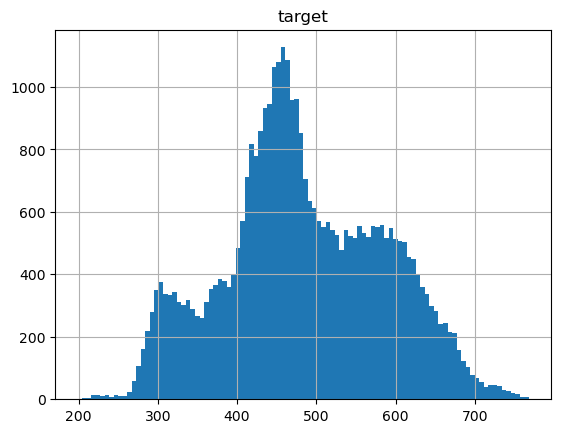

-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.06%
Количество нулевых значений: 1551,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
temp
Уникальные значения
Первые 5 значений: [-21.7 -20.9]
Последние 5 значений: [32.5 32.2]
Количество уникальных значений: 474,        процент уникальных значений: 1.27%
Количество нулевых значений: 171,        процент нулевых значений: 0.46%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


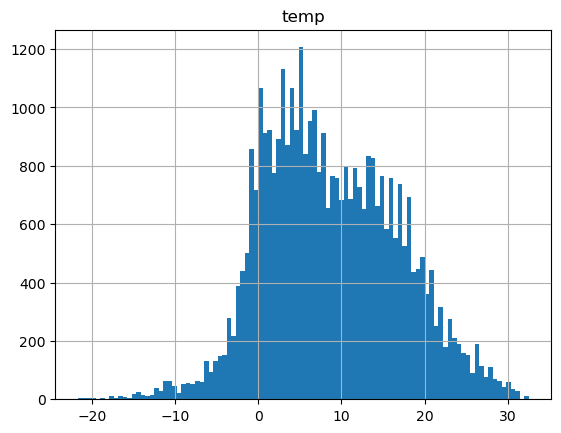

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-20. -19.]
Последние 5 значений: [33. 32.]
Количество уникальных значений: 54,        процент уникальных значений: 0.15%
Количество нулевых значений: 1506,        процент нулевых значений: 4.05%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%


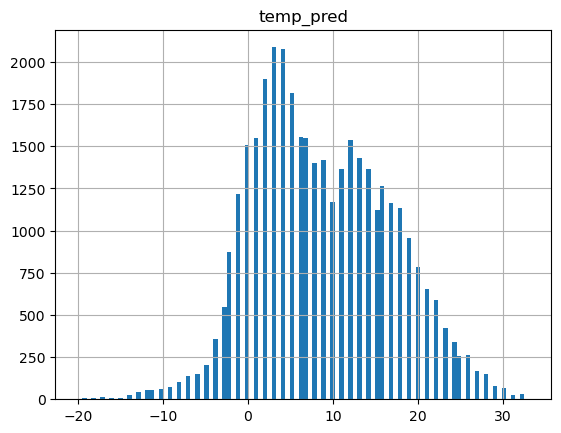

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: [' п/обл, 35% дождь']
Последние 5 значений: ['ясно,ветер']
Количество уникальных значений: 2181,        процент уникальных значений: 5.86%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: [' обл, ветер']
Последние 5 значений: ['ясно,ветерок']
Количество уникальных значений: 580,        процент уникальных значений: 1.56%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 1,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,552.96,19,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,563.985,20,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,560.191,21,6.3,5.0,"пасм, 61%","пасм, дымка"


,target,time,temp,temp_pred
count,37224.0,37224.0,37224.0,37136.0
mean,483.731,11.5,8.749,8.769
std,101.459,6.922,8.126,8.018
min,198.982,0.0,-21.7,-20.0
25%,418.951,5.75,2.6,3.0
50%,473.064,11.5,7.9,8.0
75%,561.217,17.25,14.7,15.0
max,767.888,23.0,32.5,33.0


<Figure size 640x640 with 0 Axes>

In [870]:
data_analyse(df_train, exception_list)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        2928 non-null   float64
 1   time          2928 non-null   int64  
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB
None
-------------------------
Явных дубликатов нет
-------------------------
target
Уникальные значения
Первые 5 значений: [264.819 268.716 270.401 272.039 272.483]
Последние 5 значений: [607.474 607.312 606.805 606.014 604.161]
Количество уникальных значений: 2905,        процент уникальных значений: 99.21%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значен

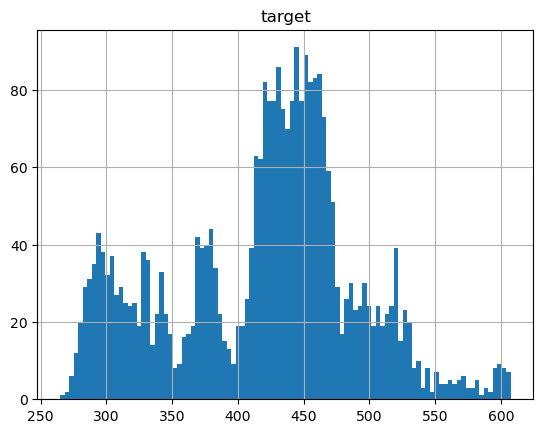

-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.82%
Количество нулевых значений: 122,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
temp
Уникальные значения
Первые 5 значений: [-3.1 -2.9]
Последние 5 значений: [31.7 30.6]
Количество уникальных значений: 270,        процент уникальных значений: 9.22%
Количество нулевых значений: 3,        процент нулевых значений: 0.1%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


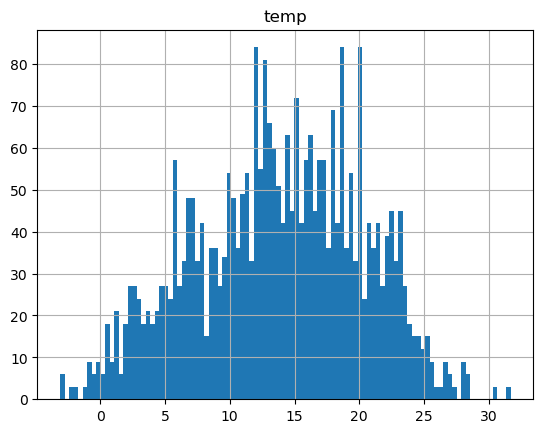

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-3.]
Последние 5 значений: [29.]
Количество уникальных значений: 32,        процент уникальных значений: 1.09%
Количество нулевых значений: 54,        процент нулевых значений: 1.84%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%


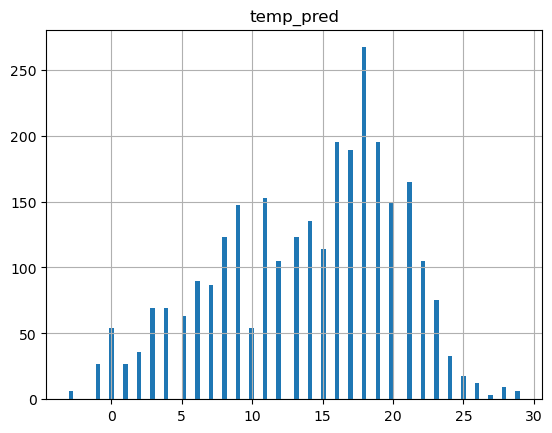

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: ['0']
Последние 5 значений: ['ясно, юго-зап.ветер' 'ясно, штиль']
Количество уникальных значений: 246,        процент уникальных значений: 8.4%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: ['дождь']
Последние 5 значений: ['ясно, хол.ветерок']
Количество уникальных значений: 121,        процент уникальных значений: 4.13%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,479.282,0,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,1,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,2,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,3,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,4,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,453.173,19,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,446.287,20,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,444.373,21,15.8,17.0,"пасм, 24% дождь",п/обл


,target,time,temp,temp_pred
count,2928.0,2928.0,2928.0,2904.0
mean,419.467,11.5,13.769,13.91
std,71.393,6.923,6.48,6.382
min,264.819,0.0,-3.1,-3.0
25%,371.384,5.75,9.2,9.0
50%,431.477,11.5,14.0,15.0
75%,462.414,17.25,18.7,19.0
max,607.474,23.0,31.7,29.0


<Figure size 640x640 with 0 Axes>

In [871]:
data_analyse(df_test, exception_list)

In [872]:
#Посмотрим на динамику среднего значения и среднеквадратичного отклонения в разрезе 30 и 160 дней
def data_std_mean(data, count_rollin):
    data_copy = data.copy()
    data_copy.sort_index(inplace=True)
    data_copy = data_copy.resample('1D').sum() 
    data_copy['mean'] = data_copy['target'].rolling(count_rollin).mean()
    data_copy['std'] = data_copy['target'].rolling(count_rollin).std()
    
    plt.figure(figsize=(20, 6))
    plt.subplot(312)
    data_copy[['target', 'mean', 'std']].plot(ax=plt.gca())
    plt.show()

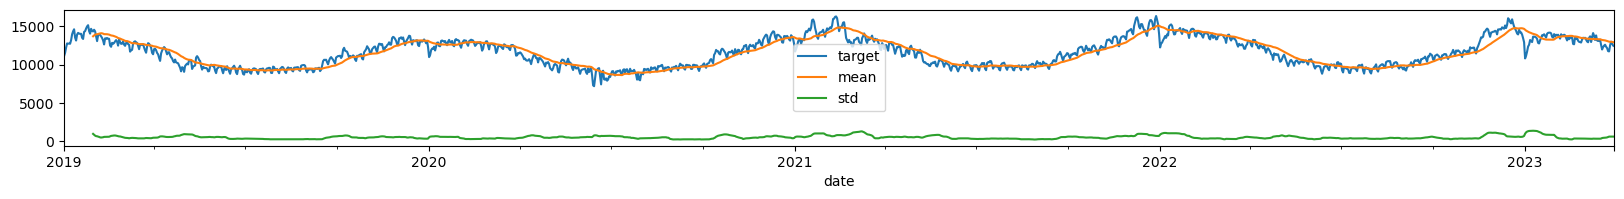

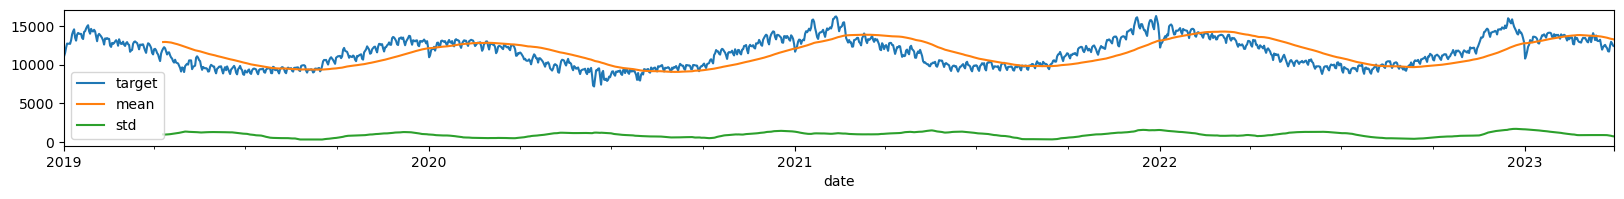

In [873]:
data_std_mean(df_train, 30)
data_std_mean(df_train, 100)

#### Тест Дики-Фуллера на стационарность

In [874]:
ts = df_train['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.572233
p-value: 0.005070
Critical Values:
	1%: -4.371
	5%: -3.833
	10%: -3.553


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины

<b>Сезонность и Тренд

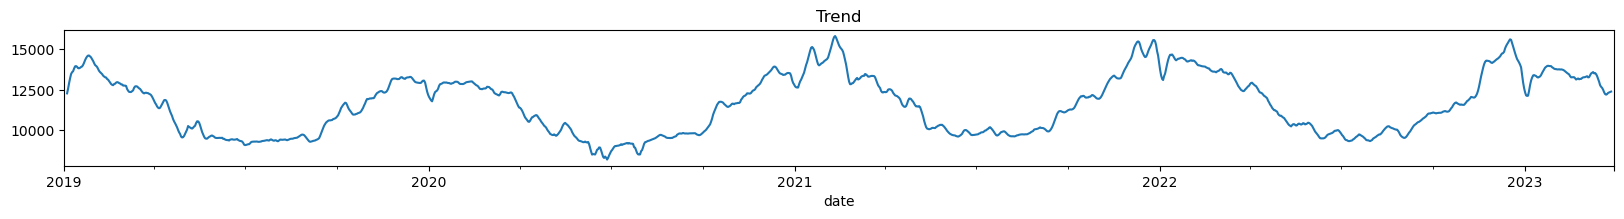

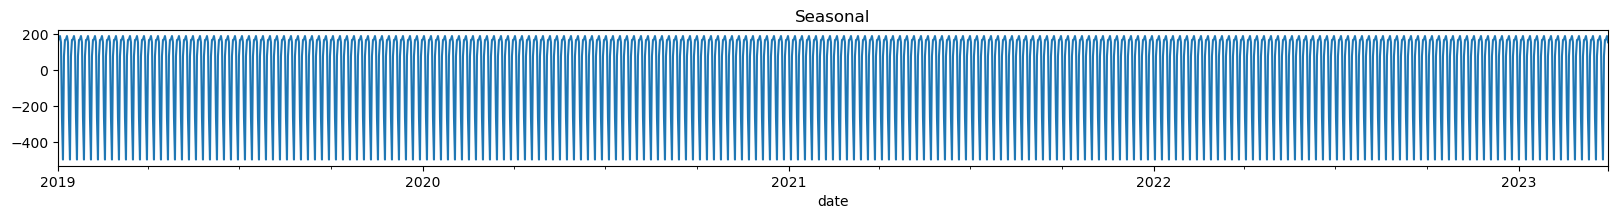

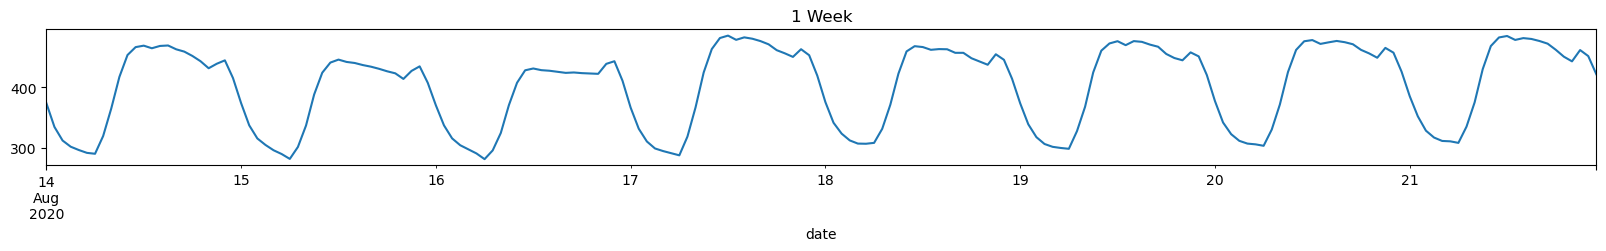

In [875]:
df = df_train['target'].resample('1D').sum() 
decomposed = seasonal_decompose(df) 
# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()
#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df_train.loc['2020-08-14':'2020-08-21', 'target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()

In [876]:
df_train.head()

,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"


In [877]:
# Функция дополнения датасета временными лагами и скользящими средними (сутки, неделя, месяц)
def make_features(df, timeshift=24, max_lag=672, rolling_mean_size=[24, 168, 672], target='target'):
    new_df = df.copy()
#     data['year'] = data.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    
    for lag in range(timeshift, max_lag + timeshift-1):
        new_df['lag_{}'.format(lag)] = new_df[target].shift(lag)

    for size in rolling_mean_size:
        new_df['roll_mean_{}'.format(size)] = new_df[target].shift(timeshift).rolling(size).mean()
  
#    new_df = new_df.dropna()
    
    return new_df

In [878]:
# Функция сдвига фактических данных температуры и погоды на одни сутки
def shift_features_fact(df, timeshift=24, list_fact_columns=['temp', 'weather_fact']):
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)
    
    return new_df

In [879]:
df_train = make_features(df_train)
df_train = shift_features_fact(df_train)
df_train = df_train.dropna()

In [880]:
df_train.head()

,target,time,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,lag_337,lag_338,lag_339,lag_340,lag_341,lag_342,lag_343,lag_344,lag_345,lag_346,lag_347,lag_348,lag_349,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,lag_401,lag_402,lag_403,lag_404,lag_405,lag_406,lag_407,lag_408,lag_409,lag_410,lag_411,lag_412,lag_413,lag_414,lag_415,lag_416,lag_417,lag_418,lag_419,lag_420,lag_421,lag_422,lag_423,lag_424,lag_425,lag_426,lag_427,lag_428,lag_429,lag_430,lag_431,lag_432,lag_433,lag_434,lag_435,lag_436,lag_437,lag_438,lag_439,lag_440,lag_441,lag_442,lag_443,lag_444,lag_445,lag_446,lag_447,lag_448,lag_449,lag_450,lag_451,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504,lag_505,lag_506,lag_507,lag_508,lag_509,lag_510,lag_511,lag_512,lag_513,lag_514,lag_515,lag_516,lag_517,lag_518,lag_519,lag_520,lag_521,lag_522,lag_523,la

In [881]:
df_test = make_features(df_test)
df_test = shift_features_fact(df_test)
df_test = df_test.dropna()

In [882]:
df_test.head()

,target,time,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,lag_337,lag_338,lag_339,lag_340,lag_341,lag_342,lag_343,lag_344,lag_345,lag_346,lag_347,lag_348,lag_349,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,lag_401,lag_402,lag_403,lag_404,lag_405,lag_406,lag_407,lag_408,lag_409,lag_410,lag_411,lag_412,lag_413,lag_414,lag_415,lag_416,lag_417,lag_418,lag_419,lag_420,lag_421,lag_422,lag_423,lag_424,lag_425,lag_426,lag_427,lag_428,lag_429,lag_430,lag_431,lag_432,lag_433,lag_434,lag_435,lag_436,lag_437,lag_438,lag_439,lag_440,lag_441,lag_442,lag_443,lag_444,lag_445,lag_446,lag_447,lag_448,lag_449,lag_450,lag_451,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504,lag_505,lag_506,lag_507,lag_508,lag_509,lag_510,lag_511,lag_512,lag_513,lag_514,lag_515,lag_516,lag_517,lag_518,lag_519,lag_520,lag_521,lag_522,lag_523,la

## Исследование глупой модели

В качестве глуппых предсказаний рассмотрим значения электропотребления за предыдущие сутки и скользящие средние.
Расчеты провоедем для двух вариантов временных рядов: по часам и семплированных по суткам.

Расчеты глупых предсказаний для исходного датасета (почасового):

In [883]:
# Сделаем выборку необходимых столбцов
df_test_dummy = df_test[['target', 'lag_24', 'lag_168', 'roll_mean_24', 'roll_mean_168']]

In [884]:
# Добавим данные за предыдущий год
df_test_dummy['2022'] = df_train['target'].loc['2022-04-29 23:00:00':'2022-07-30 23:00:00'].values

In [906]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
df_diff = abs(df_test_dummy['target']-df_test_dummy['lag_24'])
df_diff = df_diff.resample('1D').sum()
df_diff = pd.DataFrame(df_diff.iloc[1:-1])
df_diff.mean()

0   255.79020652173912
dtype: float64

In [905]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день недели
df_diff_168 = abs(df_test_dummy['target']-df_test_dummy['lag_168'])
df_diff_168 = df_diff_168.resample('1D').sum()
df_diff_168 = pd.DataFrame(df_diff_168.iloc[1:-1])
df_diff_168.mean()

0   302.5782173913043
dtype: float64

In [904]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий год
df_diff_year = abs(df_test_dummy['target']-df_test_dummy['2022'])
df_diff_year = df_diff_year.resample('1D').sum()
df_diff_year = pd.DataFrame(df_diff_year.iloc[1:-1])
df_diff_year.mean()

0   565.4359782608695
dtype: float64

In [888]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
mean_absolute_error(df_test_dummy['target'],df_test_dummy['lag_24'])*24

261.6100823902218

In [889]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (сутки)
mean_absolute_error(df_test_dummy['target'],df_test_dummy['roll_mean_24'])*24

1302.1940004526937

In [890]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (неделя)
mean_absolute_error(df_test_dummy['target'],df_test_dummy['roll_mean_168'])*24

1292.5873726961133

Расчеты глупых предсказаний для семплированного датасета:

In [891]:
# Посуточно семплируем данные
df_mod_dummy = df_test['target'].resample('1D').sum()
df_mod_dummy = pd.DataFrame(df_mod.iloc[1:-1])

In [892]:
df_mod_dummy.head()

,target,lag_1,roll_mean_7,roll_mean_30
date,,,,
2023-05-31,9451.778,9475.259,9326.326857142858,9873.159033333333
2023-06-01,9483.151,9451.778,9318.242857142857,9844.048700000001
2023-06-02,9341.364,9483.151,9327.940857142858,9794.179666666667
2023-06-03,9224.945,9341.364,9316.084142857144,9735.065866666668
2023-06-04,9080.638,9224.945,9330.745428571428,9672.480333333335


In [893]:
# Сделаем выборку необходимых столбцов
df_mod_dummy = make_features(df_mod, timeshift=1, max_lag=2, rolling_mean_size=[7, 30])
df_mod_dummy = df_mod[['target', 'lag_1', 'roll_mean_7', 'roll_mean_30']].dropna()

In [894]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['lag_1'])

268.2763064516129

In [895]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (неделя)
mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['roll_mean_7'])

405.6618617511523

In [896]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (месяц)
mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['roll_mean_30'])

437.1014139784948

## Обучение

In [897]:
# Разделим тренировочный датасет на выборки признаков и целевого признака
features_train = df_train.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_train = df_train['target']

# Разделим тренировочный датасет на выборки признаков и целевого признака
features_test = df_test.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_test = df_test['target']

In [898]:
pipeline = make_pipeline()
pipeline.steps.append(('regression', DummyRegressor()))
pipeline

Pipeline(steps=[('regression', DummyRegressor())])

In [899]:
# Посмотрим шаги пайплайна
pipeline.steps

[('regression', DummyRegressor())]

In [900]:
def create_randomized_search_cv(pipeline, iterations_count, parameters=None):
    if parameters is None:
        params = [
            {
                'regression': [ElasticNet()],
                'regression__l1_ratio': [0, .25, .5, .75, 1],
                'regression__alpha': [.1, .5, 1, 5, 10]
            },
            {
                'regression': [RandomForestRegressor()],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [CatBoostRegressor(verbose=1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [LGBMRegressor(n_jobs=-1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            }
        ]
    else:
        params = parameters

    grid = RandomizedSearchCV(pipeline,
                              params,
                              n_iter = iterations_count,
                              cv = TimeSeriesSplit(n_splits=4),
                              verbose = 1,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs=-1)

    return grid

In [421]:
grid = create_randomized_search_cv(pipeline, 30)

In [422]:
%%time

grid.fit(features_train, target_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Learning rate set to 0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Learning rate set to 0.5
Learning rate set to 0.5
0:	learn: 51.2882606	total: 836ms	remaining: 7.52s
0:	learn: 52.6241904	total: 1.1s	remaining: 9.94s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172237
[LightGBM] [Info] Number of data points in the train set: 7288, number of used features: 680
[LightGBM] [Info] Start training from score 451.197119
0:	learn: 55.5473137	total

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e+05, tolerance: 5.799e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.658e+05, tolerance: 1.246e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.788e+05, tolerance: 2.099e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172237
[LightGBM] [Info] Number of data points in the train set: 7288, number of used features: 680
[LightGBM] [Info] Start training from score 451.197119
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059627 seconds.
You can set `force_col_wise=tr

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+06, tolerance: 1.246e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e+06, tolerance: 2.099e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.211e+05, tolerance: 5.799e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.735e+06, tolerance: 2.952e+04
  model = cd_fast.enet_coordinate_descent(


Learning rate set to 0.5
0:	learn: 51.2882606	total: 739ms	remaining: 36.2s
Learning rate set to 0.5
1:	learn: 33.6591463	total: 1.37s	remaining: 32.9s
0:	learn: 52.6241904	total: 730ms	remaining: 35.8s
2:	learn: 24.7591603	total: 1.97s	remaining: 30.8s
1:	learn: 34.6159648	total: 1.46s	remaining: 35.1s
3:	learn: 19.4691535	total: 2.59s	remaining: 29.8s
2:	learn: 25.9321394	total: 2.15s	remaining: 33.6s
4:	learn: 17.4311564	total: 3.27s	remaining: 29.4s
3:	learn: 21.4177063	total: 2.77s	remaining: 31.9s
5:	learn: 15.7663514	total: 3.97s	remaining: 29.1s
4:	learn: 19.2837647	total: 3.42s	remaining: 30.8s
6:	learn: 14.7406061	total: 4.53s	remaining: 27.9s
5:	learn: 17.9042674	total: 4.06s	remaining: 29.8s
7:	learn: 14.1314282	total: 5.21s	remaining: 27.4s
6:	learn: 17.0197880	total: 4.72s	remaining: 29s
8:	learn: 13.7225348	total: 5.85s	remaining: 26.6s
7:	learn: 16.3442080	total: 5.29s	remaining: 27.7s
9:	learn: 13.2257186	total: 6.48s	remaining: 25.9s
8:	learn: 15.6764967	total: 5.93s	

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+06, tolerance: 1.246e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


9:	learn: 15.1975779	total: 6.55s	remaining: 26.2s
11:	learn: 12.5002879	total: 7.78s	remaining: 24.6s
10:	learn: 14.8987377	total: 7.34s	remaining: 26s
12:	learn: 12.1302888	total: 8.6s	remaining: 24.5s
Learning rate set to 0.5
11:	learn: 14.6488817	total: 8.03s	remaining: 25.4s
13:	learn: 11.8016020	total: 9.46s	remaining: 24.3s
0:	learn: 55.5473137	total: 937ms	remaining: 45.9s
12:	learn: 14.2785203	total: 8.89s	remaining: 25.3s
14:	learn: 11.5689980	total: 10.3s	remaining: 23.9s
1:	learn: 36.2861535	total: 1.88s	remaining: 45.2s
13:	learn: 14.0571869	total: 9.68s	remaining: 24.9s
15:	learn: 11.1981430	total: 11s	remaining: 23.4s
2:	learn: 26.5530915	total: 2.72s	remaining: 42.6s
14:	learn: 13.8067147	total: 10.5s	remaining: 24.6s
16:	learn: 11.0161374	total: 11.8s	remaining: 22.9s
3:	learn: 22.0702552	total: 3.64s	remaining: 41.9s
15:	learn: 13.4658283	total: 11.5s	remaining: 24.4s
17:	learn: 10.8666742	total: 12.6s	remaining: 22.4s
4:	learn: 19.6465536	total: 4.57s	remaining: 41.1

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e+06, tolerance: 2.099e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


42:	learn: 7.9424401	total: 36.2s	remaining: 5.9s
31:	learn: 10.2512890	total: 29s	remaining: 16.3s
47:	learn: 5.6054430	total: 37.8s	remaining: 1.57s
43:	learn: 7.8317168	total: 37s	remaining: 5.05s
32:	learn: 10.0691591	total: 29.9s	remaining: 15.4s
48:	learn: 5.5140012	total: 38.7s	remaining: 790ms
44:	learn: 7.7713138	total: 38s	remaining: 4.22s
33:	learn: 9.9208787	total: 30.8s	remaining: 14.5s
49:	learn: 5.4257563	total: 39.5s	remaining: 0us
Learning rate set to 0.5
45:	learn: 7.7166706	total: 38.9s	remaining: 3.39s
34:	learn: 9.7942486	total: 31.5s	remaining: 13.5s
46:	learn: 7.5772564	total: 39.8s	remaining: 2.54s
0:	learn: 56.8201040	total: 1.12s	remaining: 54.9s
35:	learn: 9.6532333	total: 32.5s	remaining: 12.6s
47:	learn: 7.4886427	total: 40.6s	remaining: 1.69s
1:	learn: 35.6580631	total: 2.03s	remaining: 48.7s
36:	learn: 9.5585876	total: 33.4s	remaining: 11.7s
48:	learn: 7.3678400	total: 41.3s	remaining: 844ms
2:	learn: 25.4652839	total: 2.9s	remaining: 45.4s
37:	learn: 9.4

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+05, tolerance: 5.799e+03
  model = cd_fast.enet_coordinate_descent(


17:	learn: 13.1632100	total: 14s	remaining: 24.8s
18:	learn: 12.9505653	total: 14.5s	remaining: 23.7s
19:	learn: 12.6749564	total: 15.3s	remaining: 23s


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 2.952e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


20:	learn: 12.4410243	total: 16s	remaining: 22s
21:	learn: 12.2292420	total: 16.6s	remaining: 21.2s
22:	learn: 12.0922646	total: 17.3s	remaining: 20.3s
23:	learn: 11.9361995	total: 17.9s	remaining: 19.4s
24:	learn: 11.7286670	total: 18.6s	remaining: 18.6s
25:	learn: 11.4893455	total: 19.3s	remaining: 17.8s
26:	learn: 11.2948752	total: 19.9s	remaining: 16.9s
27:	learn: 11.0899368	total: 20.6s	remaining: 16.2s
28:	learn: 10.9387700	total: 21.1s	remaining: 15.3s
29:	learn: 10.8524283	total: 21.8s	remaining: 14.5s


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.266e+05, tolerance: 1.246e+04
  model = cd_fast.enet_coordinate_descent(


30:	learn: 10.6619761	total: 22.5s	remaining: 13.8s
31:	learn: 10.5094301	total: 23.2s	remaining: 13.1s
32:	learn: 10.3688297	total: 23.8s	remaining: 12.3s
33:	learn: 10.2232352	total: 24.5s	remaining: 11.5s
34:	learn: 10.0926443	total: 25.1s	remaining: 10.8s
35:	learn: 9.9686885	total: 25.7s	remaining: 10s
36:	learn: 9.8897867	total: 26.3s	remaining: 9.26s
37:	learn: 9.8313067	total: 26.9s	remaining: 8.5s
38:	learn: 9.7321065	total: 27.5s	remaining: 7.75s
39:	learn: 9.6750440	total: 28.2s	remaining: 7.06s
40:	learn: 9.5764199	total: 28.9s	remaining: 6.35s
41:	learn: 9.4251864	total: 29.6s	remaining: 5.63s
42:	learn: 9.3446295	total: 30.1s	remaining: 4.9s
43:	learn: 9.2317256	total: 30.8s	remaining: 4.2s
44:	learn: 9.1215811	total: 31.4s	remaining: 3.48s
45:	learn: 9.0511429	total: 32s	remaining: 2.78s
46:	learn: 8.9501017	total: 32.6s	remaining: 2.08s
47:	learn: 8.8586053	total: 33.2s	remaining: 1.39s


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+06, tolerance: 2.099e+04
  model = cd_fast.enet_coordinate_descent(


48:	learn: 8.8025618	total: 33.8s	remaining: 690ms
49:	learn: 8.7353830	total: 34.4s	remaining: 0us


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e+06, tolerance: 2.952e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.265e+03, tolerance: 5.799e+03
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172237
[LightGBM] [Info] Number of data points in the train set: 7288, number of used features: 680
[LightGBM] [Info] Start training from score 451.197119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+05, tolerance: 5.799e+03
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e+05, tolerance: 1.246e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

CPU times: user 1min 6s, sys: 2.25 s, total: 1min 8s
Wall time: 39min


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('regression', DummyRegressor())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'regression': [ElasticNet(alpha=0.5,
                                                                   l1_ratio=1)],
                                         'regression__alpha': [0.1, 0.5, 1, 5,
                                                               10],
                                         'regression__l1_ratio': [0, 0.25, 0.5,
                                                                  0.75, 1]},
                                        {'regression': [RandomForestR...
                                         'regression__max_depth': [5, 10, 20],
                                         'regression__n_estimators': [10, 50,
                                                                      100]},
                                        {'regression': [<catboost.core.CatBoostRegressor object at 0x7ff98daaeb50>],
                                         'regression__max_depth': [5, 10, 20],
                                         'regression__n_estimators': [10, 50,
                                                                      100]},
                                        {'regression': [LGBMRegressor(n_jobs=-1)],
                                         'regression__max_depth': [5, 10, 20],
                                         'regression__n_estimators': [10, 50,
                                                                      100]}],
                   scoring='neg_mean_absolute_error', verbose=1)

In [423]:
# Посмотрим лучшиую модель и ее параметры
grid.best_params_

{'regression__l1_ratio': 1,
 'regression__alpha': 0.5,
 'regression': ElasticNet(alpha=0.5, l1_ratio=1)}

In [424]:
# Посмотрим получившуюся лучшую метрику RMSE
abs(grid.best_score_)

10.432952176665763

## Тестирование

In [425]:
%%time

predictions = pd.DataFrame(grid.predict(features_test), index=target_test.index)
predictions

CPU times: user 43.4 ms, sys: 0 ns, total: 43.4 ms
Wall time: 7.07 ms


,0
date,
2023-04-29 23:00:00,486.6918446417975
2023-04-30 00:00:00,441.5053848239343
2023-04-30 01:00:00,404.7489661594599
2023-04-30 02:00:00,383.809516168875
2023-04-30 03:00:00,373.26501475612866
...,...
2023-07-31 19:00:00,450.19171255216133
2023-07-31 20:00:00,439.7209472422259
2023-07-31 21:00:00,446.29025226190583


In [426]:
mae = mean_absolute_error(target_test, predictions)
mae

8.598296881597479

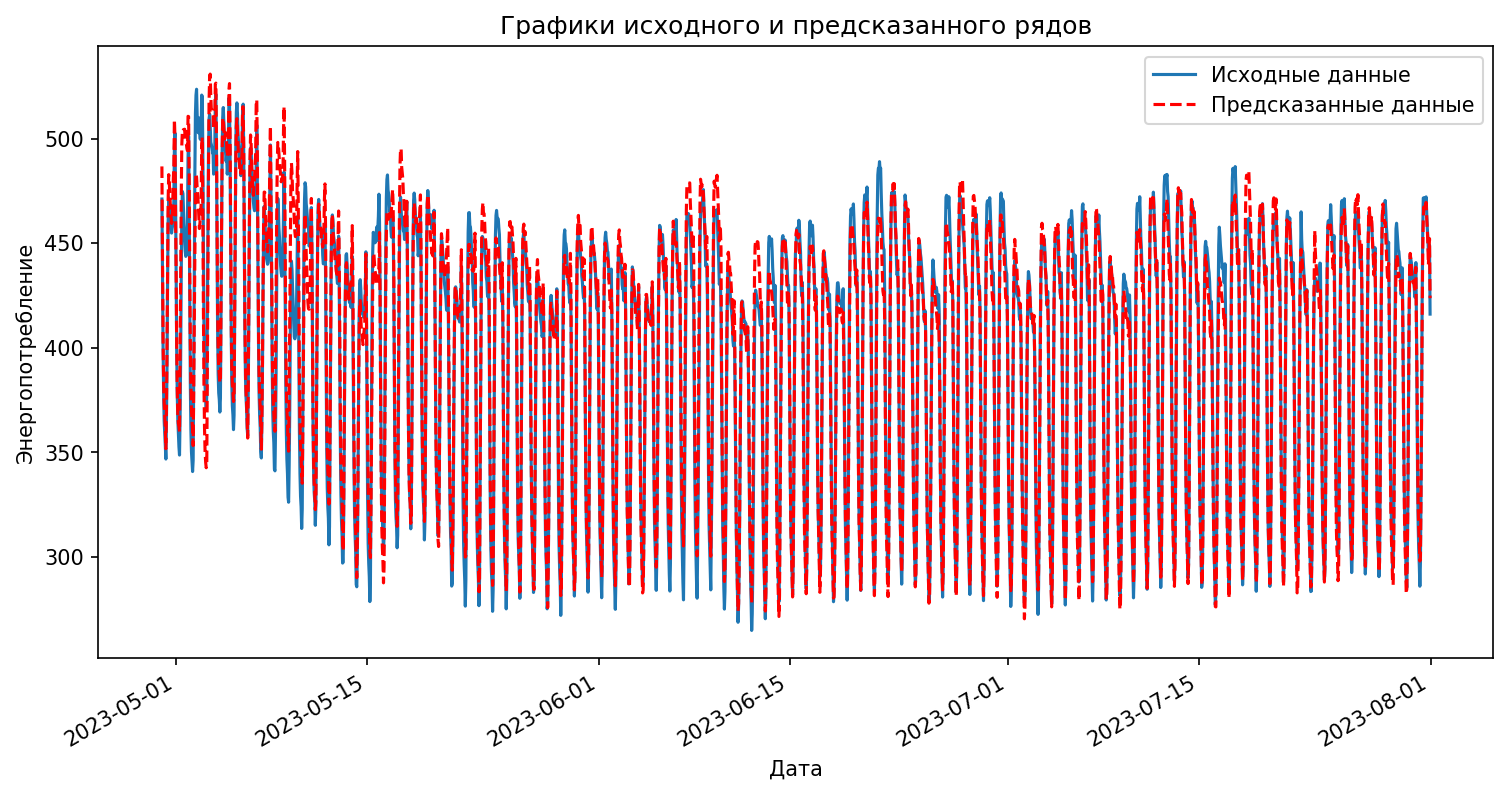

In [427]:
# Визуализируем графики исходного и предсказанного рядов
plt.figure(figsize=(12,6), dpi=150)
target_test.plot(label='1')
predictions[0].plot(label='2',style='r--')
plt.title('Графики исходного и предсказанного рядов')
plt.ylabel('Энергопотребление')
plt.xlabel('Дата')
plt.legend(('Исходные данные', 'Предсказанные данные'))
plt.show()

## LSTM

In [907]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math

In [925]:
# Нормализуем данные в тренировочном и тестовом датасетах
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(df_train.drop(['weather_pred', 'weather_fact'], axis=1))
test = scaler.transform(df_test.drop(['weather_pred', 'weather_fact'], axis=1))

In [909]:
# Разделим тренировочный датасет на массивы признаков и целевого признака
trainX  = np.delete(train, 0, 1)
trainY = train[:, 0]

# Разделим тренировочный датасет на массивы признаков и целевого признака
testX  = np.delete(test, 0, 1)
testY = test[:, 0]

In [910]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [911]:
%%time
# Создадим и обучим нейросеть
model = Sequential()
model.add(LSTM(100, input_shape=(1, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=256, verbose=2, shuffle=False)

Epoch 1/400
143/143 - 2s - loss: 0.0982 - 2s/epoch - 12ms/step
Epoch 2/400
143/143 - 0s - loss: 0.1540 - 454ms/epoch - 3ms/step
Epoch 3/400
143/143 - 0s - loss: 0.1266 - 449ms/epoch - 3ms/step
Epoch 4/400
143/143 - 0s - loss: 0.1255 - 444ms/epoch - 3ms/step
Epoch 5/400
143/143 - 0s - loss: 0.1191 - 451ms/epoch - 3ms/step
Epoch 6/400
143/143 - 0s - loss: 0.1237 - 446ms/epoch - 3ms/step
Epoch 7/400
143/143 - 0s - loss: 0.1459 - 464ms/epoch - 3ms/step
Epoch 8/400
143/143 - 0s - loss: 0.1233 - 453ms/epoch - 3ms/step
Epoch 9/400
143/143 - 0s - loss: 0.1386 - 454ms/epoch - 3ms/step
Epoch 10/400
143/143 - 0s - loss: 0.1239 - 475ms/epoch - 3ms/step
Epoch 11/400
143/143 - 0s - loss: 0.1428 - 496ms/epoch - 3ms/step
Epoch 12/400
143/143 - 0s - loss: 0.1340 - 470ms/epoch - 3ms/step
Epoch 13/400
143/143 - 0s - loss: 0.1380 - 452ms/epoch - 3ms/step
Epoch 14/400
143/143 - 0s - loss: 0.1404 - 462ms/epoch - 3ms/step
Epoch 15/400
143/143 - 0s - loss: 0.1291 - 452ms/epoch - 3ms/step
Epoch 16/400
143/143 

In [912]:
# Сделаем прогноз для тренировочных и тестовых данных
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

70/70 [==============================] - 0s 733us/step


In [913]:
# Выполним обратную нормализацию всех данных
testX = testX.reshape(testX.shape[0], testX.shape[2])
inv_testPredict = np.concatenate((testPredict, testX), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)

trainX = trainX.reshape(trainX.shape[0], trainX.shape[2])
inv_trainPredict = np.concatenate((trainPredict, trainX), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)

inv_train = scaler.inverse_transform(train)
inv_test = scaler.inverse_transform(test)

In [926]:
# Посчитаем метрику MAE LSTM
trainScore = (mean_absolute_error(inv_train[:,0], inv_trainPredict[:, 0]))*24
print('Train Score LSTM: %.2f MAE' % (trainScore))
testScore = (mean_absolute_error(inv_test[:,0], inv_testPredict[:, 0]))*24
print('Test Score LSTM: %.2f MAE' % (testScore))

Train Score LSTM: 564.70 MAE
Test Score LSTM: 633.45 MAE
